In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import zarr
import rioxarray
import pystac_client
import odc.stac
import dask
from dask.distributed import Client
import folium
import matplotlib.pyplot as plt
from pathlib import Path
import os
import requests
import io
import zipfile
import warnings
import gc
from collections import defaultdict
from datetime import timedelta
from tqdm import tqdm

In [2]:
client = Client(processes=True,        # Each worker runs in a separate process - saver this way
                threads_per_worker=1,  # > 1 leads to multithreading issues
                n_workers=50,           # 10GB per worker
                memory_limit="500GB"   # we want to stay under 540GB
                )
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 50
Total threads: 50,Total memory: 22.74 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38425,Workers: 50
Dashboard: http://127.0.0.1:8787/status,Total threads: 50
Started: Just now,Total memory: 22.74 TiB
Comm: tcp://127.0.0.1:40855,Total threads: 1
Dashboard: http://127.0.0.1:36813/status,Memory: 465.66 GiB
Nanny: tcp://127.0.0.1:36271,


# Loading the data

In [3]:
eodc_catalog = pystac_client.Client.open("https://stac.eodc.eu/api/v1")

collection_id = "SENTINEL1_SIG0_20M"

collection = eodc_catalog.get_collection(collection_id)

### Area of Intesest

In [ ]:
# Area for testing the code (selected area so e.g. the ffill is visible)
"""
time_range ="2022-01-01/2022-03-01" 

latmin, latmax = 40, 41         # South to North
lonmin, lonmax = -6, -5           # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]
#"""

In [4]:
# Europe Africa Intersection
#"""
time_range ="2022-01-01/2022-01-15"

latmin, latmax = 35, 37            # South to North
lonmin, lonmax = -6, -5           # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]
#"""

In [ ]:
# Area and Time of Interest
"""
time_range = "2021-01-01/2023-12-31"

latmin, latmax = 30.0, 45.0            # South to North
lonmin, lonmax = -10.0, 5.0            # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]

#"""

### STAC Request

In [5]:
search = eodc_catalog.search(
    collections=collection_id,
    bbox=bounding_box,
    datetime=time_range,
    #max_items=1  # number of max items to load
)
items_eodc = search.item_collection()
print(f"On EODC we found {len(items_eodc)} items for the given search query")

On EODC we found 35 items for the given search query


### Mapping Images to Tiles in Europe and Africa

Information on the Equi7 grid: https://cartography.tuwien.ac.at/eurocarto/wp-content/uploads/2015/09/3_6_ppt.pdf

In [6]:
# Split into European and African Equi7 projections

items_crs_europe = []
items_crs_africa = []

for item in items_eodc:
    wkt = item.properties["proj:wkt2"]
    lat_center = float(wkt.split('PARAMETER["latitude_of_center",')[1].split(']')[0])  # we select based on the latitude of the center of the projection

    if lat_center == 53.0:
        items_crs_europe.append(item)
    elif lat_center == 8.5:
        items_crs_africa.append(item)

print(f"Equi7 Europe (lat 53.0): {len(items_crs_europe)} items")
print(f"Equi7 Africa (lat 8.5): {len(items_crs_africa)} items")

Equi7 Europe (lat 53.0): 17 items
Equi7 Africa (lat 8.5): 18 items


In [7]:
# Make groups for each tile

def extract_tile_id_from_name(item_id):
    parts = item_id.split("_")
    tile_id = parts[3]
    if len(tile_id) == 10:
            return tile_id

european_tiles = defaultdict(list)
african_tiles = defaultdict(list)

for item in items_crs_europe:
    tile_id = extract_tile_id_from_name(item.id)
    if item not in european_tiles[tile_id]:
        european_tiles[tile_id].append(item)

for item in items_crs_africa:
    tile_id = extract_tile_id_from_name(item.id)
    if item not in african_tiles[tile_id]:
        african_tiles[tile_id].append(item)

print(f"European tiles: {len(european_tiles)}")
print(f"African tiles: {len(african_tiles)}")
european_tiles

European tiles: 1
African tiles: 1


defaultdict(list,
            {'E030N006T3': [<Item id=SIG0_20220114T061933_D081_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220114T061908_D081_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220113T181845_A074_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220113T181820_A074_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220112T063603_D052_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220112T063538_D052_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220111T183448_A045_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220111T183423_A045_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220107T062753_D154_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220107T062728_D154_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220107T062703_D154_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id

### Selecting the T3 files

As we do not want to load all the files we select the ones that are interesting for our analysis

<img src="..\images\Tiles_Europe.jpeg" alt="Tiles of Europe" width="400">
<img src="..\images\Tiles_Africa.jpeg" alt="Tiles of Europe" width="400">


In [8]:
# Selecting 14 European tiles
european_target_tiles = {
    "E027N009T3", 
    "E030N006T3", "E030N009T3", "E030N012T3", "E030N015T3", 
    "E033N006T3", "E033N009T3", "E033N012T3", "E033N015T3", 
    "E036N006T3", "E036N009T3", "E036N012T3",
    "E039N009T3", "E039N012T3"
}

european_tiles = {
    tile_id: items
    for tile_id, items in european_tiles.items()
    if tile_id in european_target_tiles
}

# Selecting 6 African Tiles
african_target_tiles = {
    "E030N090T3", "E030N087T3",
    "E033N090T3", "E033N087T3", 
    "E036N090T3", "E036N087T3", 
}

african_tiles = {
    tile_id: items
    for tile_id, items in african_tiles.items()
    if tile_id in african_target_tiles
}

print(f"European tiles: {len(european_tiles)}")
print(f"African tiles: {len(african_tiles)}")

European tiles: 1
African tiles: 1


### Plothing Thumbnail of the data

In [9]:
# Showing thumbnail image of the data
#"""
map = folium.Map(
    location=[(latmin + latmax) / 2, (lonmin + lonmax) / 2],
    zoom_start=7,
    zoom_control=True,
    scrollWheelZoom=False,
    dragging=False,
)

folium.Rectangle(
    bounds=[[latmin, lonmin], [latmax, lonmax]],
    color="blue",
    fill=True,
    fill_opacity=0.1,
    weight=2,
    popup="Area of Interest",
).add_to(map)

for item in european_tiles['E030N006T3']:
    # url leading to display of an item, can also be used as hyperlink
    image_url = item.assets["thumbnail"].href
    bounds = item.bbox
    folium.raster_layers.ImageOverlay(
        image=image_url,
        bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
    ).add_to(map)

folium.LayerControl().add_to(map)

map
#"""

### Loading Shapefiles

In [10]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

resp = requests.get(url)

with zipfile.ZipFile(io.BytesIO(resp.content)) as z:
    folder = "../data/Shapefiles/ne_110m_admin_0_countries"
    z.extractall(folder)

shp_path = os.path.join(folder, "ne_110m_admin_0_countries.shp")
gdf = gpd.read_file(shp_path)

mask_africa_df = gdf[gdf["CONTINENT"] == "Africa"]
mask_europe_df = gdf[gdf["CONTINENT"] == "Europe"]


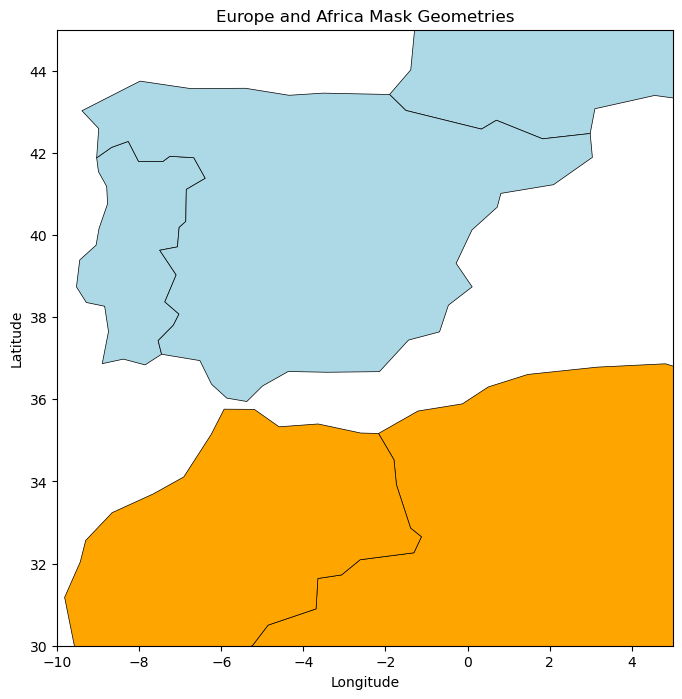

In [11]:
# visual check of area of interest
area = {
    "minx": -10.0,
    "maxx": 5,
    "miny": 30,
    "maxy": 45
}

fig, ax = plt.subplots(figsize=(10, 8))
mask_europe_df.plot(ax=ax, edgecolor="black", facecolor="lightblue", linewidth=0.5, label="Europe")
mask_africa_df.plot(ax=ax, edgecolor="black", facecolor="orange", linewidth=0.5, label="Africa")
ax.set_xlim(area["minx"], area["maxx"])
ax.set_ylim(area["miny"], area["maxy"])
plt.title("Europe and Africa Mask Geometries")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Run code tile-by-tile

In [ ]:
def process_tile(tile_id, tiles_dict, crs, output_dir, mask_df, chunk_days=30):

    res = 20
    chunks = {"time": 1, "y": 15000, "x": 15000} # it gets chunked automatically (selecting a smaller chunk size did not help and lead to issues)
    try:

        tile_items = tiles_dict[tile_id]

        all_times = pd.to_datetime([item.datetime for item in tile_items])
        start_time = all_times.min()
        end_time = all_times.max()

        print(f"Processing tile {tile_id} from {start_time} to {end_time}")

        current = start_time
        while current <= end_time:
            next_time = current + timedelta(days=chunk_days)

            items_chunk = [
                item for item in tile_items 
                if current <= pd.Timestamp(item.datetime).ceil("1h") < next_time
            ]                       # filter items within the current time range

            if not items_chunk:
                current = next_time
                continue

            sig0_dc = odc.stac.load(
                items_chunk,
                crs=crs,
                resolution=res,
                chunks=chunks,
                fail_on_error=False # as on the project pc it had problems with empty items (e.g. SIG0_20220124T063537__VV_D052_E030N006T3)
            )                       # loading it localy this somehow works automatically - on Project PC fail_on_error is nesessary

            nodata = items_chunk[0].assets["VV"].extra_fields["raster:bands"][0]["nodata"]
            scale = items_chunk[0].assets["VV"].extra_fields["raster:bands"][0]["scale"]

            sig0_dc = sig0_dc.where(sig0_dc != nodata) / scale
            sig0_dc = sig0_dc.rio.clip(mask_df.geometry.values, mask_df.crs)

            linear = 10 ** (sig0_dc / 10)
            linear.coords["time"] = linear.time.dt.ceil("1h")
            hourly = linear.groupby("time").mean(skipna=True)
            coarse = hourly.coarsen(x=300, y=300, boundary="pad").mean()
            filled = coarse.ffill(dim="time")
            back_to_db = 10 * np.log10(filled)

            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, f"{tile_id}.zarr")

            if not os.path.exists(output_path):              # write
                back_to_db.to_zarr(output_path, mode="w")
            else:                                            # or append
                back_to_db.to_zarr(output_path, mode="a", append_dim="time")

            print(f"[{tile_id}] Appended {back_to_db.time.size} timesteps from {current.date()} to {next_time.date()}")

            # Clean up memory
            del sig0_dc, linear, hourly, coarse, filled, back_to_db
            gc.collect()

            current = next_time

    except Exception as e:
        print(f"Error processing tile {tile_id}: {e}")


## Processing European Tiles

In [ ]:
for tile_id, items_list in tqdm(european_tiles.items(), desc="Processing European Tiles"):
    with dask.config.set(**{"array.slicing.split_large_chunks": False}):
        process_tile(
            tile_id=tile_id,
            tiles_dict=european_tiles,
            crs="EPSG:27704",  # Europe CRS
            output_dir="../data/Sentinel-1/Europe",
            mask_df=mask_europe_df
        )

## Processing African Tiles

In [ ]:
for tile_id, items_list in tqdm(african_tiles.items(), desc="Processing African Tiles"):
    with dask.config.set(**{"array.slicing.split_large_chunks": False}):
        process_tile(
            tile_id=tile_id,
            tiles_dict=african_tiles,
            crs="EPSG:27701",  # Africa CRS
            output_dir="../data/Sentinel-1/Africa",
            mask_df= mask_africa_df
        )

## FFilling the remaining time chunks

In [ ]:

folders = ["../data/Sentinel-1/Europe", "../data/Sentinel-1/Africa"]

ffill_dim = "time"

for folder in folders:
    for root, dirs, files in os.walk(folder):
        for d in dirs:
            if d.endswith(".zarr"):
                zarr_path = os.path.join(root, d)
                
                print(f"Processing {zarr_path}")
                ds = xr.open_zarr(zarr_path)
                ds_ffill = ds.ffill(dim="time")
                ds_ffill.to_zarr(zarr_path, mode="w")
                print(f"Completed forward fill for {zarr_path}")


## Inspecting the data

In [13]:
folders = [
    "../data/Sentinel-1/Europe", 
    "../data/Sentinel-1/Africa"
]

summary = []

for folder in folders:
    for root, dirs, files in os.walk(folder):
        for d in dirs:
            if d.endswith(".zarr"):
                zarr_path = os.path.join(root, d)
                
                ds = xr.open_zarr(zarr_path)   
                    
                time_values = pd.to_datetime(ds["time"].values)
                n_timesteps = len(time_values)
                first_time = time_values[0]
                last_time = time_values[-1]
                    
                month_periods = pd.Series(time_values).dt.to_period("M")
                month_counts = month_periods.value_counts()
                min_obs_per_month = month_counts.min() if not month_counts.empty else 0
                months_covered = month_counts.size
                    
                summary.append([zarr_path, n_timesteps, first_time, last_time, min_obs_per_month, months_covered])

df_summary = pd.DataFrame(summary, columns=[
    "file", "timesteps", "first_time", "last_time", "min_obs_per_month", "months_covered"
])
print(df_summary.to_string(index=False))

                                     file  timesteps          first_time           last_time  min_obs_per_month  months_covered
../data/Sentinel-1/Europe/E033N012T3.zarr        948 2021-01-01 07:00:00 2023-12-29 19:00:00                 16              36
../data/Sentinel-1/Europe/E039N012T3.zarr        865 2021-01-01 07:00:00 2023-12-31 18:00:00                 15              36
../data/Sentinel-1/Europe/E030N009T3.zarr        826 2021-01-01 07:00:00 2023-12-28 07:00:00                 14              36
../data/Sentinel-1/Europe/E039N009T3.zarr        836 2021-01-02 07:00:00 2023-12-31 18:00:00                 15              36
../data/Sentinel-1/Europe/E027N009T3.zarr        623 2021-01-02 19:00:00 2023-12-27 19:00:00                  8              36
../data/Sentinel-1/Europe/E030N012T3.zarr        810 2021-01-03 07:00:00 2023-12-28 07:00:00                 12              36
../data/Sentinel-1/Europe/E036N009T3.zarr        961 2021-01-01 07:00:00 2023-12-31 18:00:00            

In [17]:
dc = xr.open_zarr("../data/Sentinel-1/Europe/E033N012T3.zarr")
dc

<xarray.Dataset> Size: 19MB
Dimensions:      (time: 948, y: 50, x: 50)
Coordinates:
    spatial_ref  int64 8B ...
  * time         (time) datetime64[ns] 8kB 2021-01-01T07:00:00 ... 2023-12-29...
  * x            (x) float64 400B 3.303e+06 3.309e+06 ... 3.591e+06 3.597e+06
  * y            (y) float64 400B 1.497e+06 1.491e+06 ... 1.209e+06 1.203e+06
Data variables:
    VH           (time, y, x) float32 9MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    VV           (time, y, x) float32 9MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>

In [18]:
dc.time.values

array(['2021-01-01T07:00:00.000000000', '2021-01-01T19:00:00.000000000',
       '2021-01-02T19:00:00.000000000', '2021-01-04T07:00:00.000000000',
       '2021-01-05T07:00:00.000000000', '2021-01-05T19:00:00.000000000',
       '2021-01-06T07:00:00.000000000', '2021-01-06T19:00:00.000000000',
       '2021-01-07T07:00:00.000000000', '2021-01-07T19:00:00.000000000',
       '2021-01-08T19:00:00.000000000', '2021-01-10T07:00:00.000000000',
       '2021-01-11T07:00:00.000000000', '2021-01-11T19:00:00.000000000',
       '2021-01-12T07:00:00.000000000', '2021-01-12T19:00:00.000000000',
       '2021-01-13T07:00:00.000000000', '2021-01-13T19:00:00.000000000',
       '2021-01-14T19:00:00.000000000', '2021-01-16T07:00:00.000000000',
       '2021-01-17T07:00:00.000000000', '2021-01-17T19:00:00.000000000',
       '2021-01-18T07:00:00.000000000', '2021-01-18T19:00:00.000000000',
       '2021-01-19T07:00:00.000000000', '2021-01-19T19:00:00.000000000',
       '2021-01-20T19:00:00.000000000', '2021-01-22

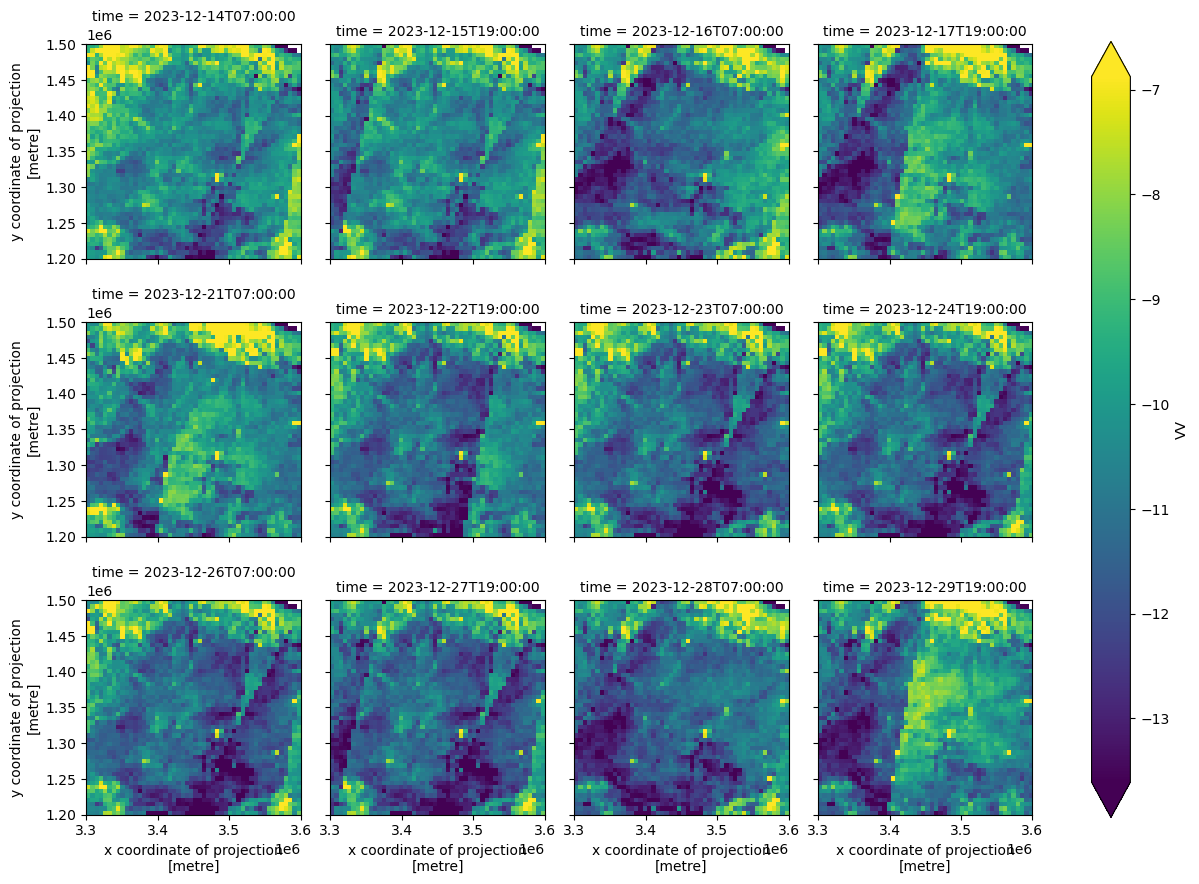

In [21]:
dc_to_plot = dc.isel(time=slice(-12, None))

fg = dc_to_plot.VV.plot.imshow(col="time", col_wrap=4, robust=True)
[ax.set_aspect('equal') for ax_row in fg.axs for ax in ax_row]
plt.show()

# Testing the Code


In [ ]:
#crs = "EPSG:27704" # Europe
crs = "EPSG:27701" # Africa

chunks = {"time": 1, "y": 15000, "x": 15000}
sig0_dc = odc.stac.load(
    #european_tiles['E036N006T3'],
    african_tiles['E030N090T3'],
    resolution=20, # errror if not set
    crs=crs,                                       
    chunks=chunks,
)

nodata = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["nodata"]
scale = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["scale"]

sig0_dc = sig0_dc.where(sig0_dc != nodata) / scale

#sig0_dc = sig0_dc.rio.clip(mask_africa_df.geometry.values, mask_africa_df.crs)
#sig0_dc = sig0_dc.rio.clip(mask_europe_df.geometry.values, mask_europe_df.crs)

sig0_dc

### Processing

In [ ]:
# Transform to linear scale to do calculations 
sig0_dc_linear = 10 ** (sig0_dc / 10)

# Merge in time direction 
sig0_dc_linear.coords['time'] = sig0_dc_linear.time.dt.ceil('1h')
sig0_dc_linear_hourly = sig0_dc_linear.groupby('time').mean(skipna=True)

# Lower the resolution from 20m to 6km  
sig0_dc_linear_6km = sig0_dc_linear_hourly.coarsen(x=300, y=300, boundary='pad').mean() # 15000/300 = 50 pixels in x and y direction (for masked data this is smaller)

# ffill values 
sig_dc_linear_6km_filled = sig0_dc_linear_6km.ffill(dim="time")

# Convert back to dB
sig_dc_6km = 10 * np.log10(sig_dc_linear_6km_filled)

In [ ]:
sig_dc_6km.to_zarr("output_6km_filled.zarr", mode="w") 

In [ ]:
ax = plt.gca()
sig_dc_6km.isel(time=0).VV.plot.imshow()
ax.set_aspect('equal')
plt.show()

### Plotting Processing steps for Verification
Some plotting to verify if the code produces the intended output

In [ ]:
# Show steps visually:

sig0_dc_linear.VV.plot.imshow(col="time", col_wrap=3, robust=True)
plt.show()

sig0_dc_linear_hourly.VV.plot.imshow(col="time", col_wrap=2, robust=True)
plt.show()

sig0_dc_linear_6km.VV.plot.imshow(col="time", col_wrap=2, robust=True)
plt.show()

sig_dc_linear_6km_filled.VV.plot.imshow(col="time", col_wrap=2, robust=True)
plt.show()
#"""